## Imports

In [167]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time

tf.random.set_seed(5)

## Data Loading

In [168]:
# Load data
from sklearn.datasets import load_digits
data = load_digits()

x = data.images
y = data.target

# Shuffle data
x, y = shuffle(x, y, random_state=0)

# Normalize data
x = x.reshape(-1, 8, 8, 1).astype("float32") / 16.0

# Split data 80/10/10
x_train, x_remaining, y_train, y_remaining = train_test_split(x, y, train_size=0.8)
x_valid, x_test, y_valid, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5) # split remaining 20% into 10% and 10%

In [169]:
# convert to tensorflow tensors
x_train = tf.convert_to_tensor(np.array(x_train, dtype=np.float32), dtype=tf.float32)
y_train = tf.convert_to_tensor(np.array(y_train, dtype=np.float32), dtype=tf.float32)
x_test = tf.convert_to_tensor(np.array(x_test, dtype=np.float32), dtype=tf.float32)
y_test = tf.convert_to_tensor(np.array(y_test, dtype=np.float32), dtype=tf.float32)
x_valid = tf.convert_to_tensor(np.array(x_valid, dtype=np.float32), dtype=tf.float32)
y_valid = tf.convert_to_tensor(np.array(y_valid, dtype=np.float32), dtype=tf.float32)

## Defining CNN

In [170]:
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu', dtype='float32', padding = 'same', input_shape = (8,8,1))
        self.pool = layers.MaxPool2D(pool_size = 2)
        self.conv2 = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same')
        self.fc1 = layers.Dense(units = 32, activation = 'relu')
        self.fc2 = layers.Dense(units = 10, activation = 'softmax')
        self.flat = layers.Flatten()
            
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## Regular SGD

In [171]:
# hyperparameters
epochs = 30
batch = int(np.sqrt(len(x_train)))
lr = 0.1

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [172]:
def train_sgd(x_train, y_train, x_valid, y_valid, model, epoch_num, batch_size):
    train_accuracies = []
    valid_accuracies = []

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    val_dataset = val_dataset.batch(batch_size)

    for epoch in range(epoch_num):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fcn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            train_acc_metric.update_state(y_batch_train, logits)
        train_accuracy = float(train_acc_metric.result())
        train_accuracies.append(train_accuracy)
        train_acc_metric.reset_states()

        for step, (x_batch_valid, y_batch_valid) in enumerate(val_dataset):
            val_logits = model(x_batch_valid, training=False)
            valid_acc_metric.update_state(y_batch_valid, val_logits)
        valid_accuracy = float(valid_acc_metric.result())
        valid_accuracies.append(valid_accuracy)
        valid_acc_metric.reset_states()

        print("Epoch", epoch+1, "Training Accuracy: ", train_accuracy, ", Validation Accuracy: ",  valid_accuracy)
    return train_accuracies, valid_accuracies


In [173]:
sgd_model = CNN()
train_accuracies_regular, valid_accuracies_regular = train_sgd(x_train, y_train, x_valid, y_valid, sgd_model, epochs, batch)
output = sgd_model(tf.Variable(x_test))

acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
print(float(acc.result()))

# ind_max_amp=np.argmax(output.numpy(), axis=1, out=None)
# print(np.mean(y_test == ind_max_amp))

Epoch 1 Training Accuracy:  0.23034098744392395 , Validation Accuracy:  0.27222222089767456
Epoch 2 Training Accuracy:  0.41405707597732544 , Validation Accuracy:  0.5888888835906982
Epoch 3 Training Accuracy:  0.6645789742469788 , Validation Accuracy:  0.7555555701255798
Epoch 4 Training Accuracy:  0.8037578463554382 , Validation Accuracy:  0.9166666865348816
Epoch 5 Training Accuracy:  0.8830897808074951 , Validation Accuracy:  0.9166666865348816
Epoch 6 Training Accuracy:  0.9199721813201904 , Validation Accuracy:  0.9444444179534912
Epoch 7 Training Accuracy:  0.9318023920059204 , Validation Accuracy:  0.9611111283302307
Epoch 8 Training Accuracy:  0.9450243711471558 , Validation Accuracy:  0.9722222089767456
Epoch 9 Training Accuracy:  0.9568545818328857 , Validation Accuracy:  0.9777777791023254
Epoch 10 Training Accuracy:  0.9652053117752075 , Validation Accuracy:  0.9888888597488403
Epoch 11 Training Accuracy:  0.9721642136573792 , Validation Accuracy:  0.9833333492279053
Epoch

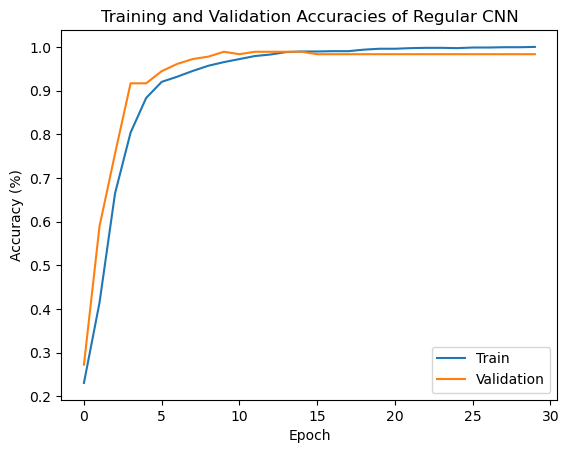

In [174]:
plt.title("Training and Validation Accuracies of Regular CNN")
plt.plot(train_accuracies_regular, label="Train")
plt.plot(valid_accuracies_regular, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

## DP-SGD

In [242]:
# hyperparameters
epochs = 30
batch = 100
lr = 0.01
sigma = 4
C = 1 
#r = 10 # number of JL projections

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [247]:
def train_dp_sgd(x_train, y_train, x_valid, y_valid, model, epoch_num, batch_size):
    train_accuracies = []
    valid_accuracies = []

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    val_dataset = val_dataset.batch(batch_size)

    for epoch in range(epoch_num):
        # Sample a batch from the dataset
        #batch_data = train_dataset.sample(batch_size)
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        # Compute the gradients for each sample in the batch
            grads = []
            for i in range(len(x_batch_train)):
                x = tf.expand_dims(x_batch_train[i], 0)
                y = tf.expand_dims(y_batch_train[i], 0)
                with tf.GradientTape() as tape:
                    # Compute the loss for the sample
                    loss = loss_fcn(model(x), y)
                # Compute the gradients for the sample
                sample_grads = tape.gradient(loss, model.trainable_variables)
                # Clip the L2 norm of the gradients
                sample_grads, _ = tf.clip_by_global_norm(sample_grads, C)
                # Add Gaussian noise to the gradients
                noise = tf.random.normal(shape=sample_grads.shape, stddev=sigma*C/batch_size)
                sample_grads += noise
                # Append the noisy gradients to the list of gradients for the batch
                grads.append(sample_grads)
        
            # Compute the average gradient for the batch
            avg_grads = [tf.reduce_mean(g, axis=0) for g in grads]
            
            # Update the model parameters using the average gradient
            model.optimizer.apply_gradients(zip(avg_grads, model.trainable_variables))
    

    # for epoch in range(epoch_num):
    #     grads = []
    #     for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    #         with tf.GradientTape() as tape:
    #             logits = model(x_batch_train, training=True)
    #             loss_value = loss_fcn(y_batch_train, logits)
    #         grads = tape.gradient(loss_value, model.trainable_variables)

    #         clipped_grads, _ = tf.clip_by_global_norm(grads, C)
    #         print(len(clipped_grads))
    #         clipped_grads_tensor = tf.stack(clipped_grads)
    #         clipped_grads_tensor = tf.reshape(clipped_grads_tensor, [batch_size, -1])

    #         # Loop over samples in the batch
    #         train_acc = []
    #         for i in range(len(x_batch_train)):
    #             noise = tf.random.normal(tf.shape(clipped_grads_tensor), stddev=sigma)
    #             #noise = tf.reshape(noise, tf.shape(clipped_grads))
    #             sample_grads = [clipped_grads[j][i] + noise[j][i] for j in range(len(clipped_grads))]
    #             optimizer.apply_gradients(zip(sample_grads, model.trainable_variables))
    #             train_acc_metric.update_state(y_batch_train[i], logits[i,:])
    #             train_accuracy = float(train_acc_metric.result())
    #             train_acc.append(train_accuracy)
    #             train_samples += 1
    #             train_acc_metric.reset_states()

    #     val_acc = []
    #     for step, (x_batch_valid, y_batch_valid) in enumerate(val_dataset):
    #         val_logits = model(x_batch_valid, training=False)
    #         for i in range(len(x_batch_valid)):
    #             valid_acc_metric.update_state(y_batch_valid[i], val_logits[i,:])
    #             valid_accuracy = float(valid_acc_metric.result())
    #             val_acc.append(valid_accuracy)
    #             val_samples += 1
    #             valid_acc_metric.reset_states()

    #     train_accuracy = np.sum(train_acc) / train_samples
    #     valid_accuracy = np.sum(val_acc) / val_samples

        print("Epoch", epoch+1)#, "Training Accuracy: ", train_accuracy, ", Validation Accuracy: ",  valid_accuracy)
    return train_accuracies, valid_accuracies

In [248]:
dp_sgd_model = CNN()
train_accuracies_dp, valid_accuracies_dp = train_dp_sgd(x_train, y_train, x_valid, y_valid, dp_sgd_model, epochs, batch)
output = dp_sgd_model(tf.Variable(x_test))

acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
print(float(acc.result()))

ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(10,) and logits.shape=(1, 1)

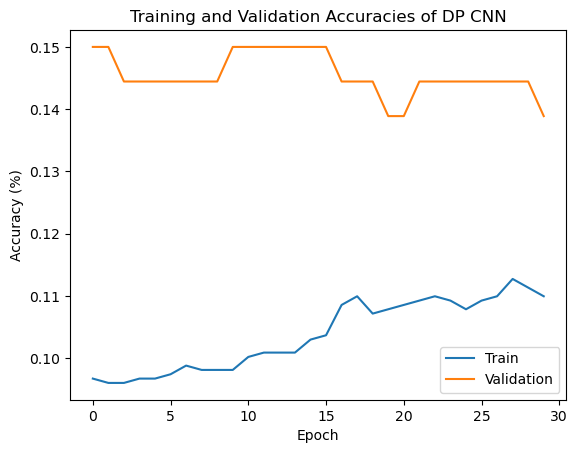

In [213]:
plt.title("Training and Validation Accuracies of DP CNN")
plt.plot(train_accuracies_dp, label="Train")
plt.plot(valid_accuracies_dp, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

## DP-SGD-JL

In [249]:
# hyperparameters
epochs = 30
batch = 100
lr = 0.01
sigma = 4
C = 2 
r = 10 # number of JL projections

# functions
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [250]:
def train_dp_sgd_jl(x_train, y_train, x_valid, y_valid, model, epoch_num, batch_size):
    train_accuracies = []
    valid_accuracies = []

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    val_dataset = val_dataset.batch(batch_size)

    for epoch in range(epoch_num):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            start = time.time()

            per_sample_grads = []
            F = []      # store losses
            V = []      # store gaussian variables

            for j in range(1, r):
                v = tf.random.normal([tf.shape(x_batch_train[0])])
                V.append(v)

            for i in range(len(x_batch_train)):
                with tf.GradientTape() as tape:
                    logits = model(tf.expand_dims(x_batch_train[i], 0), training=True)
                    loss_value = loss_fcn(tf.expand_dims(y_batch_train[i], 0), logits)
                    F.append(loss_value)
                P = []
                for j in range(1, r):
                    with tf.autodiff.ForwardAccumulator(tf.constant(F[i]), tf.constant(V[i])) as acc:
                        P.append(acc.jvp(loss_fcn()))
                    # jvp for all v and keep adding the square over r

                M = tf.reduce_mean(tf.constant(P))

                sample_loss = min(1, C/M)*F[i]

                grads_i = tape.gradient(sample_loss, model.trainable_weights)
                # grads_i = [tf.clip_by_norm(g, C) for g in grads_i]
                per_sample_grads.append([g/batch for g in grads_i])
                train_acc_metric.update_state(tf.expand_dims(y_batch_train[i], 0), logits)

            sum = per_sample_grads[0]
            for i in range(1, len(per_sample_grads)):
                sum += per_sample_grads[i]

            four = time.time()

            noise = sigma*C*(1/batch)*tf.random.normal(tf.shape(sum[0]))
            grads = sum + noise

            five = time.time()
            print('Time to add noise', five-four)

            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            print('Time to apply gradients:', time.time()-five)
            print('Total time to complete batch:', time.time()-start)

        train_accuracy = float(train_acc_metric.result())
        train_accuracies.append(train_accuracy)
        train_acc_metric.reset_states()

        for step, (x_batch_valid, y_batch_valid) in enumerate(val_dataset):
            val_logits = model(x_batch_valid, training=False)
            valid_acc_metric.update_state(y_batch_valid, val_logits)
        valid_accuracy = float(valid_acc_metric.result())
        valid_accuracies.append(valid_accuracy)
        valid_acc_metric.reset_states()

        print("Epoch", epoch+1, "Training Accuracy: ", train_accuracy, ", Validation Accuracy: ",  valid_accuracy)
    return train_accuracies, valid_accuracies

In [251]:
dp_sgd_jl_model = CNN()
train_accuracies_dp, valid_accuracies_dp = train_dp_sgd_jl(x_train, y_train, x_valid, y_valid, dp_sgd_jl_model, epochs, batch)
output = dp_sgd_model(tf.Variable(x_test))

acc = keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_test, output)
print(float(acc.result()))

InvalidArgumentError: {{function_node __wrapped__RandomStandardNormal_device_/job:localhost/replica:0/task:0/device:CPU:0}} shape must be a vector of {int32,int64}, got shape [1,3] [Op:RandomStandardNormal]

In [ ]:
plt.title("Training and Validation Accuracies of DP CNN")
plt.plot(train_accuracies_dp, label="Train")
plt.plot(valid_accuracies_dp, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()